In [2]:
import numpy as np
from scipy.stats import invgamma
from scipy.linalg import toeplitz
from sklearn.linear_model import Lasso
from tqdm import tqdm
import matplotlib.pyplot as plt 

In [3]:
# calculer vx
def calculate_vx(X):
    
    variances = np.var(X, axis=0)
    vx = np.mean(variances)
    return vx

In [4]:
def unnormalized_density_R2_q(R2_grid, q_grid, beta, z, sigma2, a, b, A, B, k, v_x):
    s_z = np.sum(z)
    R2_grid, q_grid = np.meshgrid(R2_grid, q_grid, indexing='ij')

    beta_term = beta.T @ np.diag(z) @ beta
    part1 = np.exp(-k * v_x * q_grid * (1 - R2_grid) * beta_term / (2 * sigma2 * R2_grid))
    part2 = q_grid**(s_z + s_z/2 + a - 1) * (1 - q_grid)**(k - s_z + b - 1)
    part3 = R2_grid**(A - 1 - s_z/2) * (1 - R2_grid)**(s_z/2 + B - 1)

    return part1 * part2 * part3





In [5]:

def sample_R2_q(beta, z, sigma2, a, b, A, B, k, v_x, R2_grid, q_grid):
    unnormalized_density = unnormalized_density_R2_q(R2_grid, q_grid, beta, z, sigma2, a, b, A, B, k, v_x)
    probabilities = unnormalized_density.flatten() / unnormalized_density.sum()

    chosen_index = np.random.choice(range(len(probabilities)), p=probabilities)
    q_index, R2_index = np.unravel_index(chosen_index, unnormalized_density.shape)

    return R2_grid[R2_index], q_grid[q_index]

In [6]:
def U_transpose_U_inv(U):
    return np.linalg.inv(U.T @ U)
    

In [7]:
def sample_phi(Y, U_T_U_inv, X, U, beta, sigma2):
    mu_phi = U_T_U_inv @ U.T @ (Y - X @ beta)
    cov_phi = sigma2 * U_T_U_inv
    phi_sample = np.random.multivariate_normal(mu_phi, cov_phi)
    
    return phi_sample


In [8]:
# Retirer le regresseur pour lesquels les coéfficients sont nuls
def X_dimi(X, z):
    return np.delete(X, (1 - z).astype('bool'), axis = 1)

In [9]:
def sample_z(Y, U, X, phi, R2, q, gamma2, z_preced):

    k = X.shape[1]
    T = X.shape[0]
    z_sample = z_preced
    for i in range(k):
      # On calcule la probabilité conditionnelle non normalisé de z_i égale 1

        z_sample[i] = 1
        X_adjusted = X_dimi(X, z_sample)
        
        # Calculer W et Y ajusté
        
        W_adjusted = (X_adjusted.T @ X_adjusted + np.eye(int(sum(z_sample)))/ gamma2)
        Y_adjusted = Y #- np.dot(U, phi)
        beta_adjusted = np.linalg.inv( W_adjusted) @  X_adjusted.T @  Y_adjusted
        
        # Calculer la probabilité de z_i étant 1
        prob_zi_1 = q * ((1 - q) * np.sqrt(gamma2)) ** (-1) * np.sqrt(np.linalg.det(W_adjusted))**(-1) * (0.5 * (np.dot(Y_adjusted.T, Y_adjusted) - np.dot(beta_adjusted.T, np.dot(W_adjusted, beta_adjusted)))) ** (-0.5 * T)
       
         # On calcule la probabilité conditionnelle non normalisé de z_i égale 0
        
        z_sample[i] = 0
        X_adjusted = X_dimi(X, z_sample)
        
        # Calculer W et Y ajusté
        
        W_adjusted = (X_adjusted.T @ X_adjusted + np.eye(int(sum(z_sample)))/ gamma2)
        beta_adjusted = np.linalg.inv( W_adjusted) @  X_adjusted.T @  Y_adjusted
        
        
        prob_zi_0 = np.sqrt(np.linalg.det(W_adjusted))**(-1) * (0.5 * (np.dot(Y_adjusted.T, Y_adjusted) - np.dot(beta_adjusted.T, np.dot(W_adjusted, beta_adjusted))))** (-0.5 * T)
                              
        # Normaliser pour obtenir une probabilité
        prob_zi_1 /= (prob_zi_1 + prob_zi_0)

        # Tirer un échantillon pour z_i
        z_sample[i] = np.random.binomial(1, prob_zi_1)

    return z_sample


In [10]:
def sample_sigma2(Y, U, X, phi, R2, z, gamma2, T):
    a = 0.5 * T
    Y_adjusted = Y # - np.dot(U, phi)
    X_adjusted = X_dimi(X, z)
    W_adjusted = (X_adjusted.T @ X_adjusted + np.eye(int(sum(z)))/ gamma2)
    beta_adjusted = np.linalg.inv( W_adjusted) @  X_adjusted.T @  Y_adjusted
    Mat = beta_adjusted.T @ (X_adjusted.T @ X_adjusted + np.eye(np.sum(z))/(gamma2)) @ beta_adjusted
    
    b = 0.5* (Y_adjusted.T @ Y_adjusted - 0.5 * Mat)

    return invgamma.rvs(a=a, scale=b)

In [11]:
def sample_beta(Y, U, X, phi, q, sigma2, z, gamma2):
    
    X_adjusted = X_dimi(X, z)
    Mat = X_adjusted.T @ X_adjusted + np.eye(np.sum(z))/(gamma2)

    mean_beta = np.linalg.inv(Mat) @ X_adjusted.T @ (Y) # - np.dot(U, phi)
    cov_beta = sigma2 * np.linalg.inv(Mat)
    beta_sample = np.random.multivariate_normal(mean_beta, cov_beta)

    return beta_sample


In [12]:
# Fonction pour générer la matrice de corrélation de Toeplitz
def generate_toeplitz_matrix(k, rho):
    return toeplitz(rho ** np.arange(0, k))


In [13]:
# Fonction pour standardiser les données
def standardize_data(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [14]:
def generate_beta(k, s):
    beta = np.zeros(k)
    non_zero_indices = np.random.choice(k, s, replace=False)
    beta[non_zero_indices] = np.random.normal(0, 1, s)
    return beta

In [16]:
def generate_data(k, T, rho):
    X_raw = np.random.multivariate_normal(np.zeros(k), generate_toeplitz_matrix(k, rho), T)
    X = standardize_data(X_raw)
    return X

In [17]:
def Calculate_Y(X, Ry, s , k , T):
    Y = []
    beta = generate_beta(k, s)
    coef = 0
    for t in range(T):
        coef += np.dot(X[t].T, beta)
    sigma2 = (1 / Ry - 1) * np.mean(coef **2)
    epsilon = np.random.normal(0, np.sqrt(sigma2), T)
    for t in range(T):
        Y.append(X[t].T @ beta)
    Y = np.array(Y)
    return np.array(Y) + epsilon     

In [18]:
def beta_recontruction(beta_, z):
    beta = []
    for i in range(len(z)):
        beta.append(z[i] * beta_[np.sum(z[:i+1]) - 1])
    return np.array(beta)  

In [34]:
def gibbs_sampling(X, Y, num_iterations, burn_in):
    
    k = X.shape[1]
    phi = np.zeros(0)
    U = 0
    
    # Initialisation 
    lasso = Lasso(alpha=0.2)
    lasso.fit(X, Y)
    beta = lasso.coef_
    z = np.where(beta != 0, 1, 0)
    residuals = Y - X @ beta
    sigma2 = np.var(residuals)
    
    q_sample = []
    v_x = calculate_vx(X)
    for _ in range(num_iterations):
        # Mise à jour de R2 et q et calcul de gamma2
        R2, q = sample_R2_q(beta, z, sigma2, a, b, A, B, v_x, k, R2_grid, q_grid)
        gamma2 = R2/(q * k * v_x * (1 - R2) )
        q_sample.append(q)
        
        # Pas besoin de mettre à jour phi
        
        # Mise à jour de z
        z = sample_z(Y, U , X, phi, R2, q, gamma2, z)
        
        # Mise à jour de sigma2
        sigma2 = sample_sigma2(Y, U, X, phi, R2, z, gamma2, T)
        
        # Mise à jour de beta tilde et calcul de beta
        beta_tilde = sample_beta(Y, U, X, phi, q, sigma2, z, gamma2)
        beta = beta_recontruction(beta_tilde, z)  

    return q_sample[burn_in:]


In [27]:
# Paramètres nécessaires
k = 100
T = 200
rho = 0.75  
s_values = [5, 10, 100]  
Ry_values = [0.02, 0.25, 0.50]  
a = b = A = B = 1 
num_iterations = 1500
burn_in = 800
U = 0

In [21]:
#Génération de 100 data sets
datasets_X = [generate_data(k, T, rho)  for _ in range(100)]

In [22]:
# Discretiser le support de R2 et q
q_grid = np.concatenate([np.arange(0.000001, 0.1, 0.001), np.arange(0.11, 0.9, 0.01), np.arange(0.901, 0.999999, 0.001)])
R2_grid = np.concatenate([np.arange(0.000001, 0.1, 0.001), np.arange(0.11, 0.9, 0.01), np.arange(0.901, 0.999999, 0.001)])


  0%|          | 0/110000 [00:00<?, ?it/s]

100%|██████████| 110000/110000 [4:35:39<00:00,  6.65it/s]  


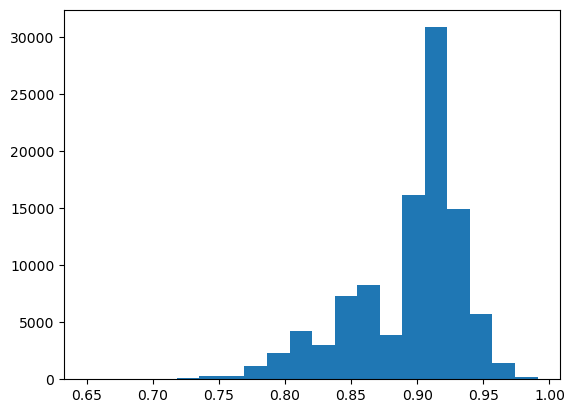

In [92]:
X= datasets_X[0]
Y = Calculate_Y(X, Ry= 0.25, s = 5 , k =100 , T = 200)
q_sample_burn_in = gibbs_sampling(X, Y, num_iterations = 110000, burn_in =10000)
plt.hist(q_sample_burn_in, bins= 20)
plt.show()

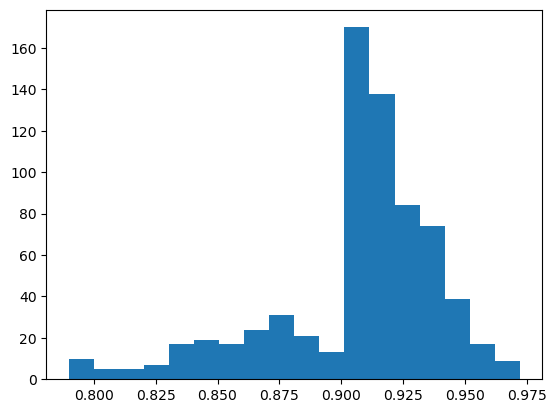

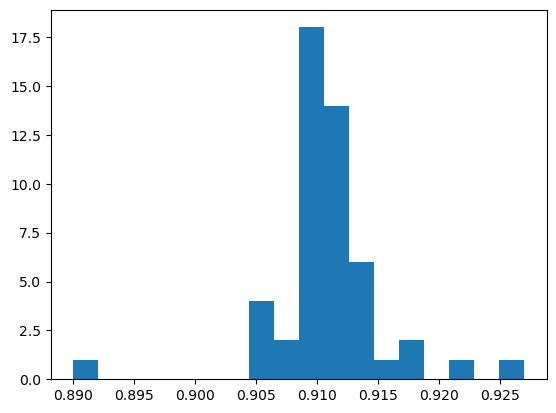

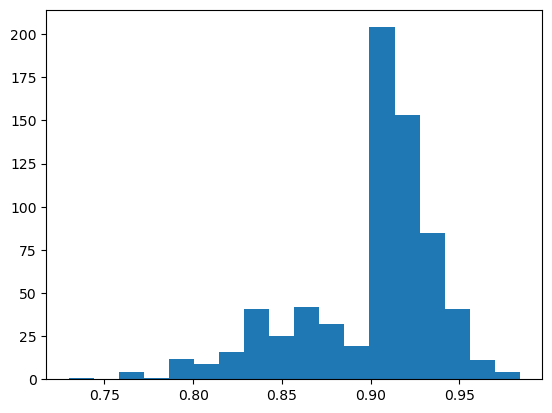

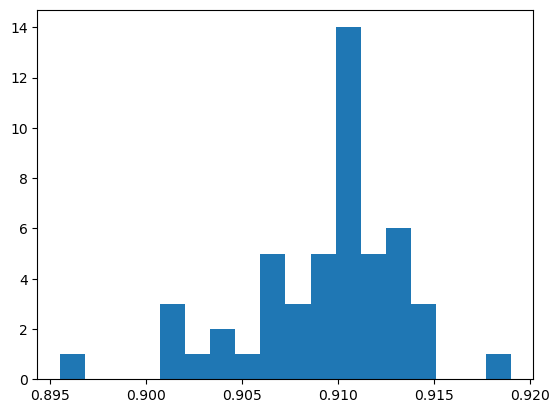

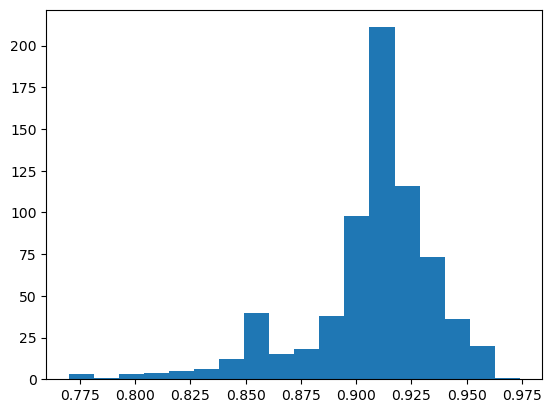

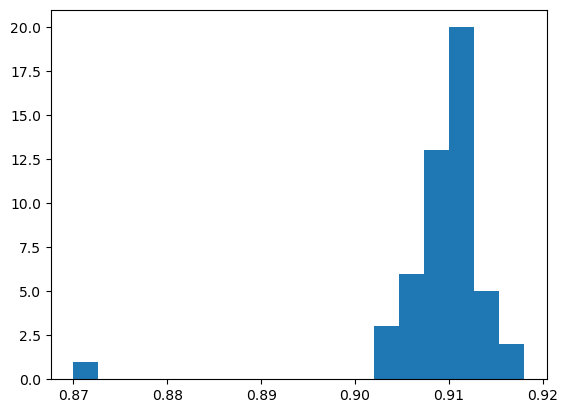

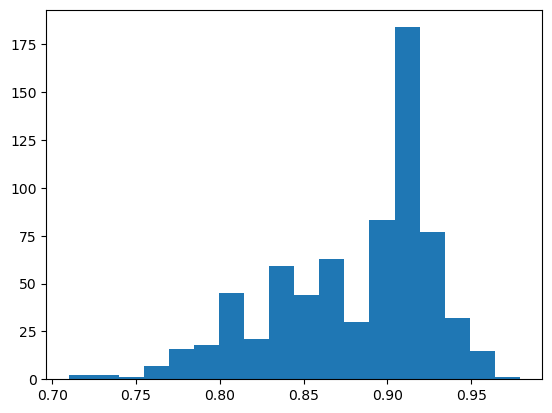

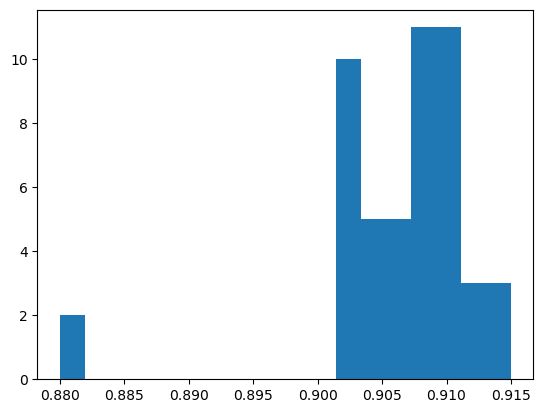

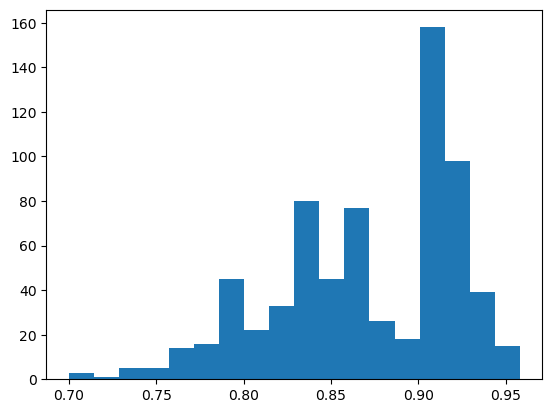

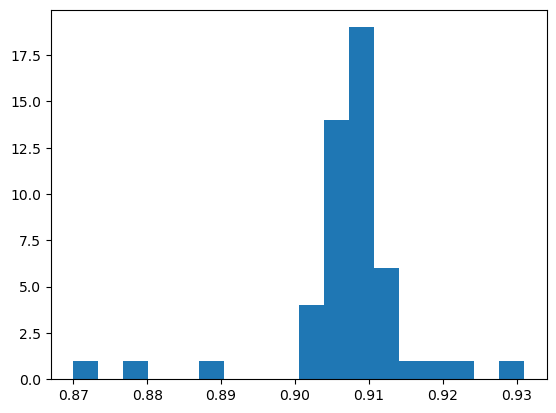

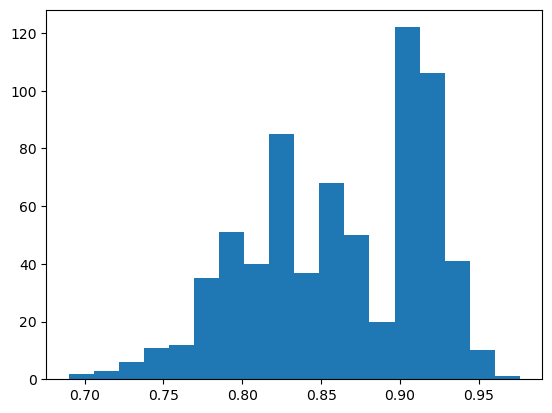

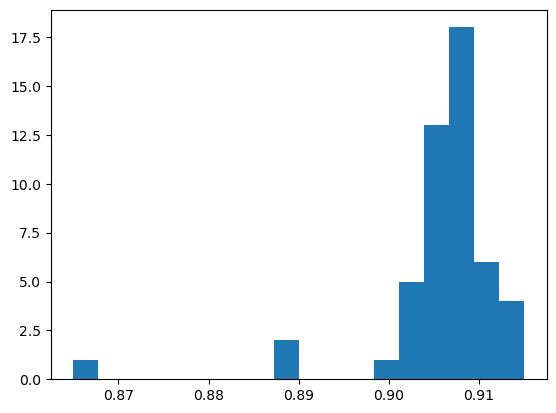

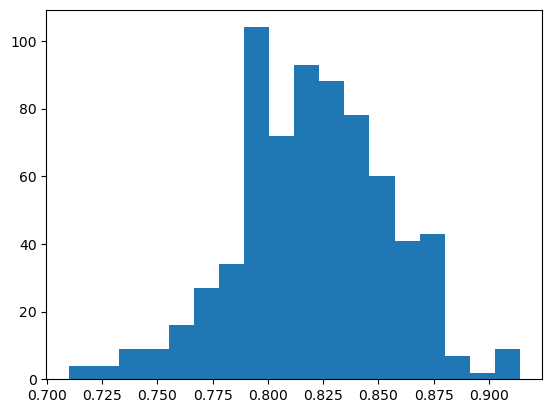

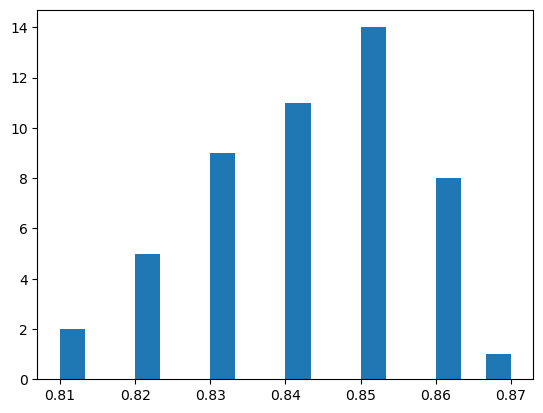

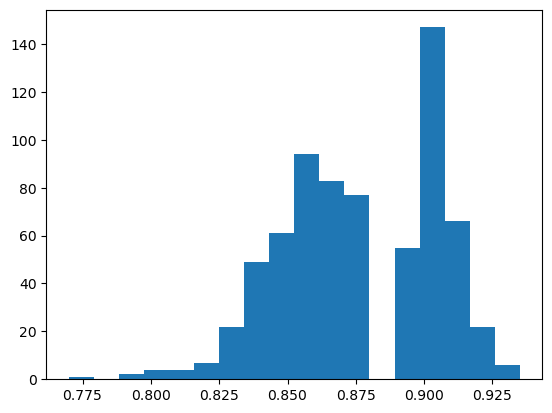

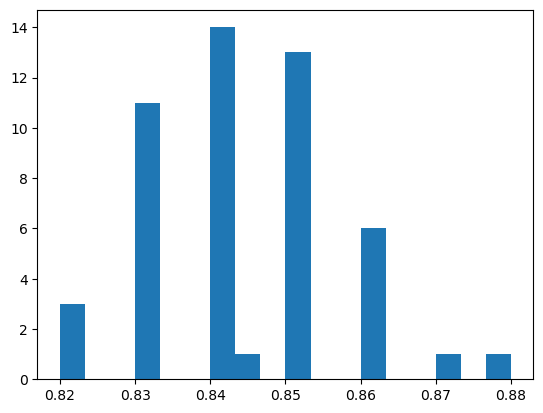

KeyboardInterrupt: 

In [37]:
for s in s_values:
    for Ry in Ry_values :
        q_median = []
        for d in range(50):  
            X = datasets_X[d]
            Y = Calculate_Y(X, Ry, s , k , T)
            q_sample_burn_in = gibbs_sampling(X, Y, num_iterations, burn_in)
            q_median.append(np.median(q_sample_burn_in))
        plt.hist(np.array(q_sample_burn_in), bins=18, label = "distribution of q")
        plt.show()
        plt.hist(np.array(q_median), bins= 18, label= "median")
        plt.show()